<a href="https://colab.research.google.com/github/gregory-ch/shap_flex_porting/blob/main/shap_joint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Discovery and Shapley Values Example

###1. Libraries installation

In [2]:
!pip install catboost==1.2.8
!pip install shap==0.47.2
!pip install igraph==0.11.8
!pip install shapflex==0.0.2
!pip install causal-learn==0.1.4.1
!pip install pandas==1.5.3
!pip install numpy==1.24.4

###2. Data downloading

 source: [Data](https://github.com/ShawhinT/YouTube-Blog/blob/main/causality/causal_discovery/df_causal_discovery.p), [Tutorial](https://towardsdatascience.com/causal-discovery-6858f9af6dcb)

In [3]:
import pickle
import matplotlib.pyplot as plt
df = pickle.load( open( "df_causal_discovery.p", "rb") )

### 3. Setting a model to explain

In [70]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
data_to_explain = df.copy()
outcome_name = 'greaterThan50k'
outcome_col = pd.Series(data_to_explain.columns)[data_to_explain.columns==outcome_name].index[0]
X, y = data_to_explain.drop(outcome_name, axis=1), data_to_explain[outcome_name].values
model = CatBoostClassifier(iterations=10000)
model.fit(X, y, verbose=100)
def predict_function(model, data_to_explain):
  return pd.DataFrame(model.predict_proba(data_to_explain)[:, [0]])

Learning rate set to 0.005266
0:	learn: 0.6892780	total: 9ms	remaining: 1m 30s
100:	learn: 0.4915075	total: 739ms	remaining: 1m 12s
200:	learn: 0.4419287	total: 1.47s	remaining: 1m 11s
300:	learn: 0.4269281	total: 2.18s	remaining: 1m 10s
400:	learn: 0.4211700	total: 2.97s	remaining: 1m 11s
500:	learn: 0.4183080	total: 3.71s	remaining: 1m 10s
600:	learn: 0.4165378	total: 4.44s	remaining: 1m 9s
700:	learn: 0.4153002	total: 5.15s	remaining: 1m 8s
800:	learn: 0.4144293	total: 5.87s	remaining: 1m 7s
900:	learn: 0.4137281	total: 6.6s	remaining: 1m 6s
1000:	learn: 0.4131087	total: 7.3s	remaining: 1m 5s
1100:	learn: 0.4125886	total: 9.61s	remaining: 1m 17s
1200:	learn: 0.4121477	total: 12.5s	remaining: 1m 31s
1300:	learn: 0.4117578	total: 14.5s	remaining: 1m 37s
1400:	learn: 0.4114092	total: 15.3s	remaining: 1m 33s
1500:	learn: 0.4110725	total: 16s	remaining: 1m 30s
1600:	learn: 0.4107218	total: 16.7s	remaining: 1m 27s
1700:	learn: 0.4103984	total: 17.4s	remaining: 1m 24s
1800:	learn: 0.410067

###4. Non-causal case: symmetric shapley values, no prior knowledge

In [71]:
from shapflex.shapflex import shapFlex_plus

explain, reference = data_to_explain.iloc[:300, :data_to_explain.shape[1]-1], data_to_explain.iloc[:, :data_to_explain.shape[1]-1]
exmpl_of_test = shapFlex_plus(explain, model, predict_function, target_features=pd.Series([
                                                                                         "age", "inRelationship",
                                                                                         "hours-per-week", "hasGraduateDegree",
                                                                                         "isFemale", "isWhite"])
)
result = exmpl_of_test.forward()

Assembling a causal data to a format with which shap's beeswarm is able to deal

In [72]:
from shap._explanation import Explanation
values = pd.DataFrame(result['shap_effect'].values.reshape(-1, 6), columns = result['feature_name'].unique()).values
base_values = np.array([result['shap_effect intercept'][0] for i in range(explain.shape[0])])
data = explain.values
shap_values_shapflex = Explanation(values, base_values=base_values, data=data, feature_names=result.loc[:5, 'feature_name'].values)

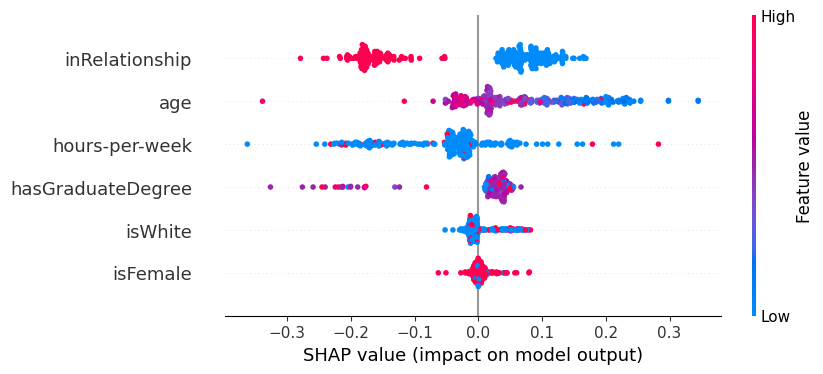

In [73]:
import shap
shap.plots.beeswarm(shap_values=shap_values_shapflex )

###5. Building a causal graph, FCI algorithm.

  step 1: Use FCI without prior knowledge

In [74]:
from causallearn.search.ConstraintBased.FCI import fci
G = fci(df.values)

  0%|          | 0/7 [00:00<?, ?it/s]

X1 --> X4
X1 --> X7
X2 --> X4
X7 --> X4
X7 --> X5


 step 2: turn off some nodes

In [76]:
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
nodes = G[0].get_nodes()
bc = BackgroundKnowledge() \
            .add_forbidden_by_node(nodes[2], nodes[0]) \
            .add_forbidden_by_node(nodes[1], nodes[2]) \
            .add_forbidden_by_node(nodes[4], nodes[5]) \
            .add_forbidden_by_node(nodes[5], nodes[4]) \
            .add_forbidden_by_node(nodes[5], nodes[0]) \
            .add_forbidden_by_node(nodes[0], nodes[5]) \
            .add_forbidden_by_node(nodes[3], nodes[4]) \
            .add_forbidden_by_node(nodes[6], nodes[4]) \
            .add_forbidden_by_node(nodes[3], nodes[5]) \
            .add_forbidden_by_node(nodes[2], nodes[4]) \
            .add_forbidden_by_node(nodes[1], nodes[4]) \
            .add_required_by_node(nodes[1], nodes[5])

G2 = fci(df.values, background_knowledge=bc)

  0%|          | 0/7 [00:00<?, ?it/s]

Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X3
Orienting edge (Knowledge): X3 --> X2
Orienting edge (Knowledge): X2 --> X6
Orienting edge (Knowledge): X5 --> X3
Orienting edge (Knowledge): X5 --> X4
Orienting edge (Knowledge): X6 --> X4
Orienting edge (Knowledge): X5 --> X7
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X3
Orienting edge (Knowledge): X3 --> X2
Orienting edge (Knowledge): X2 --> X6
Orienting edge (Knowledge): X5 --> X3
Orienting edge (Knowledge): X5 --> X4
Orienting edge (Knowledge): X6 --> X4
Orienting edge (Knowledge): X5 --> X7
Finishing BK Orientation.
X3 --> X2
X2 --> X4
X2 --> X6
X2 --> X7
X3 --> X7
X6 --> X4
X4 --> X7


###6. Assembling a causal dataframe from a causal graph

In [77]:
nodes = []
for edge in G2[1]:
  nodes.append([edge.get_node1().get_name(), edge.get_node2().get_name()])

names = {x:y for x, y in zip([
                              'X' + str(i) for i in range(1, 8)
], df.columns.values
)}

causal = pd.DataFrame()
causal['cause'] = pd.DataFrame(nodes)[0].apply(lambda x: names[x])
causal['effect'] = pd.DataFrame(nodes)[1].apply(lambda x: names[x])

We don't want to have an objective node in our graph. Also, though we turned off an edge 'hours-per-week' $\rightarrow$ 'isFemale' it somehow appeared in a graph. So, we have to delete it.

In [78]:
causal_without_objective = causal.where(causal!='greaterThan50k').dropna(axis=0)
causal_without_objective = causal_without_objective.drop(causal_without_objective.index[6]).reset_index(drop=True)
# drop(6).

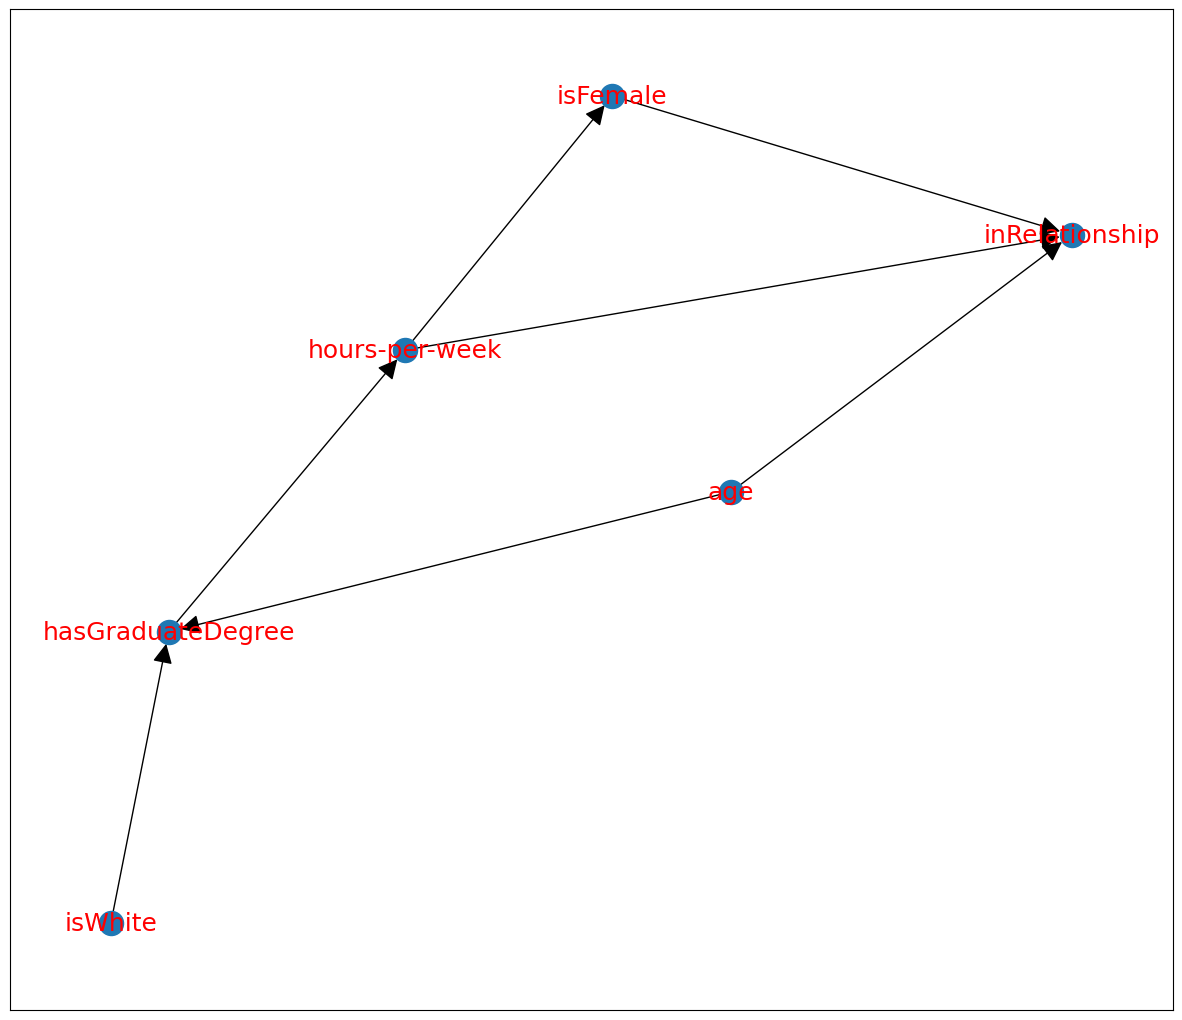

In [79]:
import networkx as nx
fig = plt.figure(figsize=(15, 13))
nx.draw_networkx(nx.from_pandas_edgelist(causal_without_objective, source='cause', target='effect', create_using=nx.classes.digraph.DiGraph), font_size=18, font_color='r', arrowsize=30)

###7. Running a causal case

In [57]:
print(causal_without_objective.head())

               cause             effect
0                age  hasGraduateDegree
1                age     inRelationship
2  hasGraduateDegree     hours-per-week
3     hours-per-week     inRelationship
4     hours-per-week           isFemale


In [80]:
exmpl_of_test = shapFlex_plus(explain, model, predict_function, target_features=pd.Series(
    ['age', 'hours-per-week', 'hasGraduateDegree', 'inRelationship',
       'isWhite', 'isFemale']), causal=causal_without_objective.columns, causal_weights=[1. for i in range(causal_without_objective.shape[0])])
result = exmpl_of_test.forward()

In [81]:
values = pd.DataFrame(result['shap_effect'].values.reshape(-1, 6), columns = result['feature_name'].unique()).values
base_values = np.array([result['shap_effect intercept'][0] for i in range(explain.shape[0])])
data = explain.values
shap_values_shapflex_2 = Explanation(values, base_values=base_values, data=data, feature_names=result.loc[:5, 'feature_name'].values)

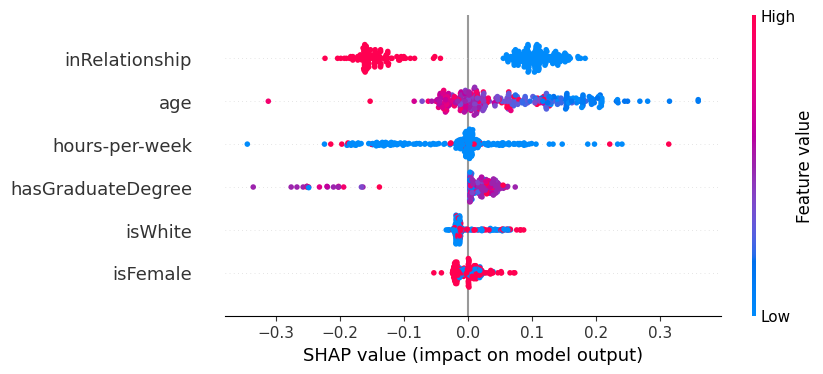

In [82]:
shap.plots.beeswarm(shap_values=shap_values_shapflex_2 )